# Imports

In [14]:
import numpy as np
import matplotlib.pyplot as plt

from py_wake.site._site import UniformSite
from py_wake.site.shear import PowerShear
from py_wake.flow_map import Points

from py_wake.examples.data.hornsrev1 import V80
from py_wake.wind_turbines import WindTurbine # Til egen mølle

from py_wake.wind_farm_models import PropagateDownwind
from py_wake.deficit_models import BastankhahGaussianDeficit
from py_wake.superposition_models import LinearSum

# Site and turbine

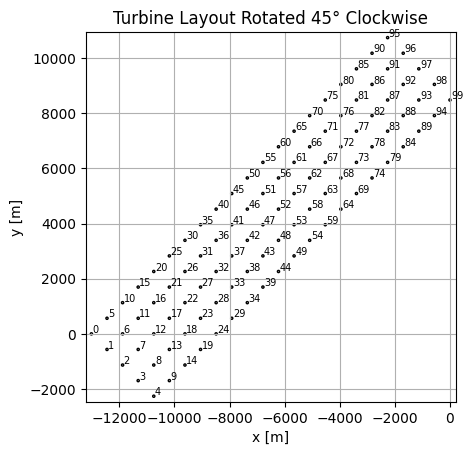

In [15]:
turbine = V80()
s = 10 * turbine.diameter()

site = UniformSite(shear=PowerShear(h_ref=turbine.hub_height(), alpha=.1))

n_rows = 20
n_cols = 5

x_grid, y_grid = np.meshgrid(np.arange(n_cols) * s,
                             np.arange(n_rows) * s)

x = x_grid.ravel()
y = y_grid.ravel()

theta_deg = 45
theta_rad = -np.radians(theta_deg)

rotation_matrix = np.array([
    [np.cos(theta_rad), -np.sin(theta_rad)],
    [np.sin(theta_rad),  np.cos(theta_rad)]
])

xy_rotated = rotation_matrix @ np.vstack([x, y])
x, y = xy_rotated[0], xy_rotated[1]

x = x - np.max(x) # Set x=0 at downstream edge

padding = 200 # Padding for display

fig, ax = plt.subplots()
turbine.plot(x, y, ax=ax)
ax.set_xlim(min(x) - padding, max(x) + padding)
ax.set_ylim(min(y) - padding, max(y) + padding)
ax.set_title(f"Turbine Layout Rotated {theta_deg}° Clockwise")
ax.set_xlabel("x [m]")
ax.set_ylabel("y [m]")
ax.set_aspect('equal')
ax.grid(True)
plt.show()

# Flow map

Text(0.5, 1.0, 'Wake map for 270 deg and 10 m/s')

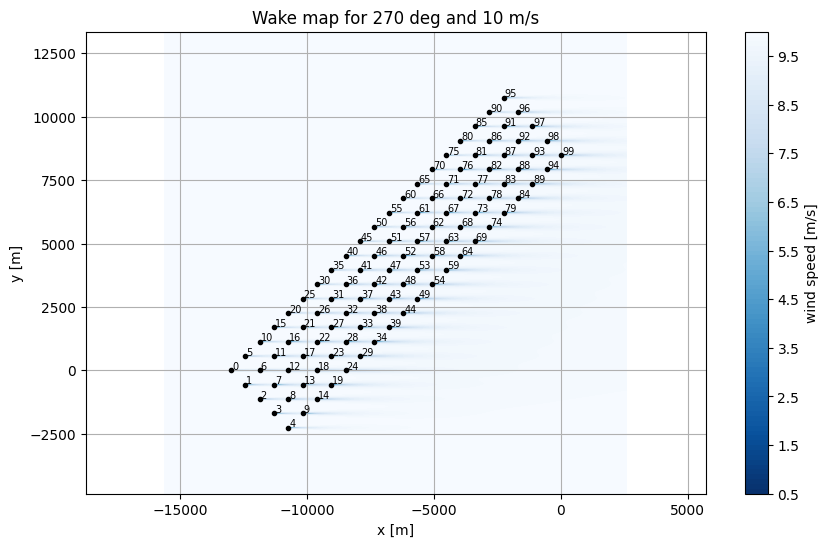

In [16]:
wdir = 270 # [deg]
wsp = 10 # [m/s]
ti = .1

wfm = PropagateDownwind(site, turbine, wake_deficitModel=BastankhahGaussianDeficit(use_effective_ws=True), superpositionModel=LinearSum())
sim = wfm(x, y, ws=wsp, wd=wdir, TI=ti)

fig, ax = plt.subplots(figsize=(10, 6))
sim.flow_map().plot_wake_map()
ax.set_xlabel("x [m]")
ax.set_ylabel("y [m]")
ax.set_aspect('equal')
ax.grid(True)
ax.set_title('Wake map for'+ f' {wdir} deg and {wsp} m/s')

# Velocity profile

In [ ]:
pl_downstream = [3, 6, 9]  # Downstream distances [Park lengths]
m_downstream = [pl * max(x) for pl in pl_downstream]  # % [m]

w_meas = 5000  # Half-width of measurement area [m]

y_range = np.linspace(min(y) - w_meas, max(y) + w_meas, w_meas)
y_meas = np.tile(y_range[:, np.newaxis], (1, len(m_downstream)))  # Shape: (num_y_points, len(m_downstream))

ws_meas = np.zeros((y_meas.shape[0], len(m_downstream)))

for i, m in enumerate(m_downstream):
    x_meas = np.full(y_meas.shape[0], max(x) + m)  # Offset m by max(x) for each y_meas row

    ws_meas[:, i] = np.squeeze(
            sim.flow_map(Points(
                x=x_meas,
                y=y_meas[:, i],
                h=turbine.hub_height() * np.ones_like(y_meas[:, i])
            )).WS_eff.values)
    
